In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#datos del banco de la reserva federal de San Luis
import pandas_datareader as pdr
import yfinance as yfin

In [2]:
#datos del petroleo BRENT, para WTI=DCOILWTICO
df = pdr.get_data_fred("DCOILBRENTEU", start="2016-01-01", end="2021-01-01")
df = df.dropna() #permite borrar celdas vacias 
df.columns = ["Close"] #Para cambiar los nombres de las columnas

#EMA 5 dias (corta)
df["EMA_short"] = df["Close"].ewm(span=5, adjust=False).mean()
#EMA 20 dias (larga)
df["EMA_long"] = df["Close"].ewm(span=20, adjust=False).mean()

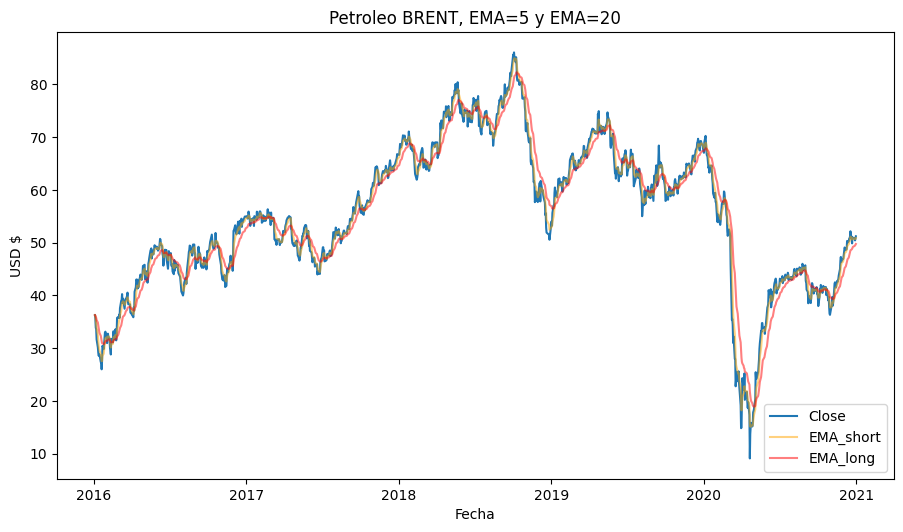

In [4]:
#Grafica de EMA
plt.figure(figsize=(10.8, 5.8))
plt.title("Petroleo BRENT, EMA=5 y EMA=20")
plt.plot(df["Close"])
plt.plot(df["EMA_short"], color="orange", alpha=0.5)
plt.plot(df["EMA_long"], color="red", alpha=0.5)
plt.xlabel("Fecha")
plt.ylabel("USD $")
plt.legend(["Close", "EMA_short", "EMA_long"], loc ="lower right")
plt.show()

In [5]:
#¿Como podemos saber cuando se cruzan las EMA?
#Calculamos el numero de datos
N =len(df)

#Lista de señalas
# -1 si vamos a vender; 0 si vamos a mantener; 1 si vamos a comprar
signals = [0] #0 suponemos que para el primer dia mantenemos posicion
for i in range(1, N): #indice comienza en 1 (el primer dato no tiene dia anterior)
  short = df["EMA_short"][i]
  long = df["EMA_long"][i]
  #ahora nos preguntamos si para el dia i las EMA se cruzan
  p_short = df["EMA_short"][i-1]
  p_long = df["EMA_long"][i-1]
  #para señal de compra
  if p_short < p_long and short >= long:
    signals.append(1)
  #para señal de venta
  elif p_short > p_long and short <= long:
    signals.append(-1)
  else:
    signals.append(0)

df["Signals"] = signals
df

,Close,EMA_short,EMA_long,Signals
DATE,,,,
2016-01-04,36.28,36.280000,36.280000,0
2016-01-05,35.56,36.040000,36.211429,0
2016-01-06,33.89,35.323333,35.990340,0
2016-01-07,33.57,34.738889,35.759832,0
2016-01-08,31.67,33.715926,35.370324,0
...,...,...,...,...
2020-12-24,50.88,50.792761,49.228966,0
2020-12-28,50.88,50.821840,49.386208,0
2020-12-29,50.44,50.694560,49.486569,0


In [6]:
#Calculamos las posiciones donde iran los triangulos nos indican las señales
df["Buy"] = np.where(df["Signals"]==1, df["Close"], np.nan)
df["Sell"] = np.where(df["Signals"]==-1, df["Close"], np.nan)

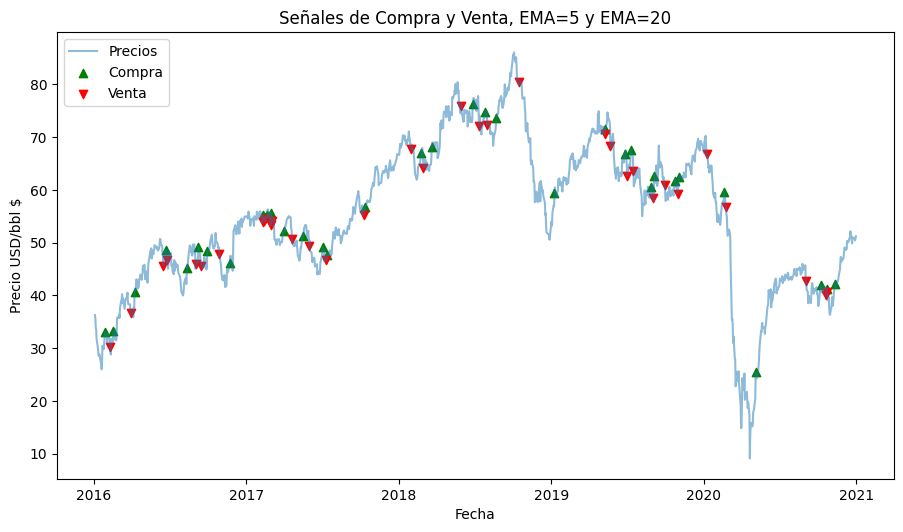

In [7]:
plt.figure(figsize=(10.8, 5.8))
plt.title("Señales de Compra y Venta, EMA=5 y EMA=20")
plt.plot(df["Close"], alpha=0.5, label="Precios")
plt.scatter(df.index, df["Buy"], color="green", marker="^", label="Compra")
plt.scatter(df.index, df["Sell"], color="red", marker="v", label="Venta")
plt.xlabel("Fecha")
plt.ylabel("Precio USD/bbl $")
plt.legend(loc ="upper left")
plt.show()

# Backtesting

In [13]:
#Backtesting nos es mas que evaluar una estrategia con datos historicos
#variable cual seria el nivel de dinero que tendremos a traves del tiempo
equity = [100] #lista, y primer element 100$

#Definimos TP y SL
TP = 0.03
SL = 0.01

#a medida que vamos avanzando en el tiempo necesitamos saber la posicion en la que estamos
pos = 0
price = 0

#Para obtener las señales de trading
for i in range(1, N):
  
  equity.append(equity[i-1])

  if pos == 1:
    if df["Close"][i] >= price*(1+TP):
      pos = 0
      equity[i] = equity[i]*(1+TP)
    elif df["Close"][i] <= price*(1-SL):
      pos = 0
      equity[i] = equity[i]*(1-SL)

  elif pos == -1:
    if df["Close"][i] <= price*(1-TP):
      pos = 0
      equity[i] = equity[i]*(1+TP)
    elif df["Close"][i] >= price*(1+SL):
      pos = 0
      equity[i] = equity[i]*(1-SL)

  else:
    if df["Signals"][i] !=0:
      pos = df["Signals"][i]
      price = df["Close"][i]
df["Equity"] = equity

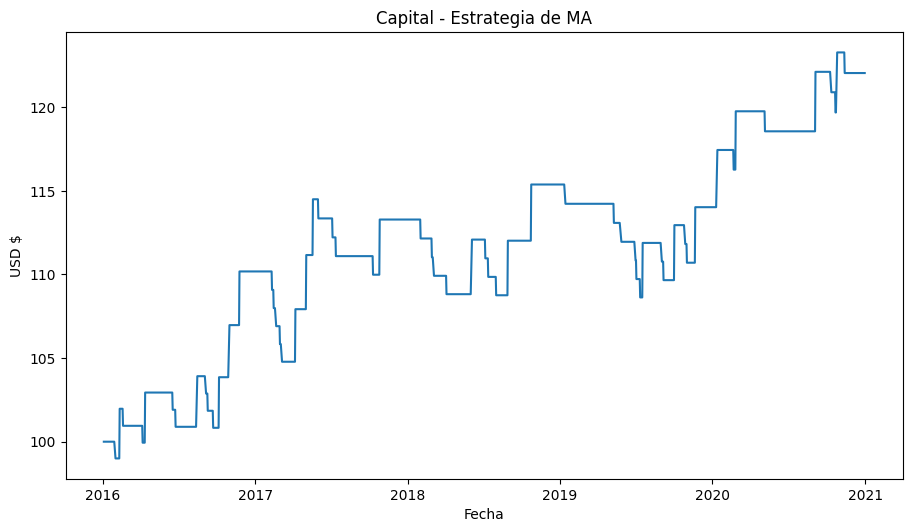

In [14]:
plt.figure(figsize=(10.8, 5.8))
plt.plot(df["Equity"])
plt.title("Capital - Estrategia de MA")
plt.xlabel("Fecha")
plt.ylabel("USD $")
plt.show()

In [19]:
#Indicador de retornos de la estrategia con la volatilidad
#retorno diario
ret =np.log(df["Equity"]).diff().mean()
#retorno anualizado
ret *= 252
ret
#volatilidad de los retornos diarios
vol = np.log(df["Equity"]).diff().std()
#Volatilidad anual
vol *= np.sqrt(252)
vol
#Tasa libre de riesgo
rf = 0.01

#Ratio de Sharp
sharp_ratio = (ret-rf)/vol
sharp_ratio

0.4519606496376969

In [24]:
df2 = yfin.download("^GSPC", start="2016-01-01", end="2021-01-01")
#Si hubieramos invertido 100 en S&P
df2["Equity"] = (100/df2["Close"][0])*df2["Close"]

[*********************100%***********************]  1 of 1 completed


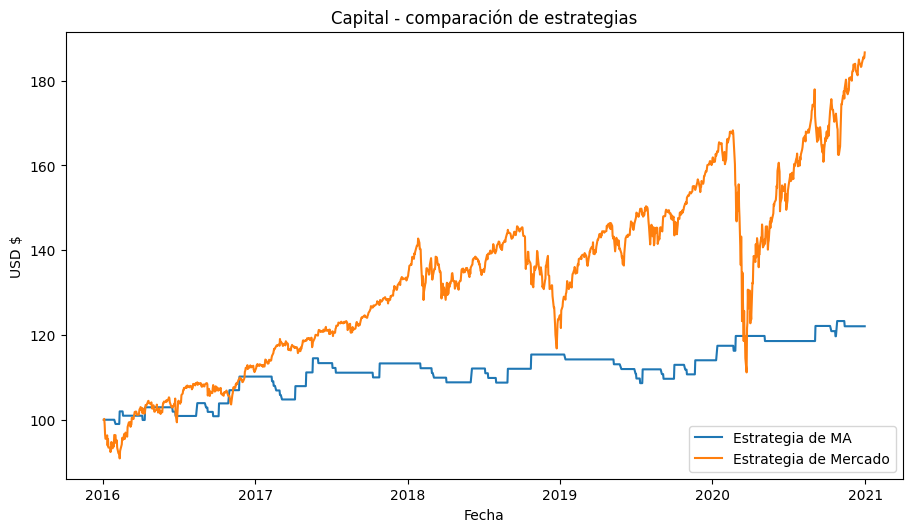

In [27]:
#Comparamos las estrategias
plt.figure(figsize=(10.8, 5.8))
plt.plot(df["Equity"], label="Estrategia de MA")
plt.plot(df2["Equity"], label="Estrategia de Mercado")
plt.title("Capital - comparación de estrategias")
plt.xlabel("Fecha")
plt.ylabel("USD $")
plt.legend(loc="lower right")
plt.show()

In [28]:
#Indicador de retornos de la estrategia con la volatilidad
#retorno diario
ret =np.log(df2["Equity"]).diff().mean()
#retorno anualizado
ret *= 252
ret
#volatilidad de los retornos diarios
vol = np.log(df2["Equity"]).diff().std()
#Volatilidad anual
vol *= np.sqrt(252)
vol
#Tasa libre de riesgo
rf = 0.01

#Ratio de Sharp
sharp_ratio = (ret-rf)/vol
sharp_ratio

0.59481054922144